# CYPLAN255
### Urban Informatics and Visualization

HIT RECORD and TRANSCRIBE

# Lecture 08 -- Intro to Data Visualization
*******
February 23, 2022

# Agenda
1. Announcements
2. Review of last session
3. Data Viz
4. For next time
5. Questions


# 1. Announcements

- Snaps for HW 1-2 Submissions
- Assignment 3 grading changes
- Irene to lead GitHub Pages tutorial
   - _will be recorded_
- New wiki section: [Things You Can Follow](https://github.com/mxndrwgrdnr/CYPLAN255/wiki/Web-Resources-and-Tutorials#things-you-can-follow)
  - newsletters, job boards, twitter accounts

# 2. Review

## 2.1 Imports and load data

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [3]:
sf1 = pd.read_hdf('data/bay_sf1_small.h5', 'sf1_extract')
sf1.head()

,logrecno,blockfips,state,county,tract,blkgrp,block,arealand,P0010001,P0020001,...,H0040003,H0040004,H0050001,H0050002,H0050003,H0050004,H0050005,H0050006,H0050007,H0050008
0,25,060014271001000,06,001,427100,1,1000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26,060014271001001,06,001,427100,1,1001,79696,113,113,...,1,4,0,0,0,0,0,0,0,0
2,27,060014271001002,06,001,427100,1,1002,739,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28,060014271001003,06,001,427100,1,1003,19546,29,29,...,0,7,3,0,0,1,0,0,0,2
4,29,060014271001004,06,001,427100,1,1004,14364,26,26,...,0,6,0,0,0,0,0,0,0,0


In [4]:
rentals = pd.read_csv(
    'data/sfbay_geocoded.csv',
    usecols=['rent', 'bedrooms', 'sqft', 'fips_block', 'longitude', 'latitude'],
    dtype={'fips_block': str}  # load fips_block as str, numeric type will drop leading zero
)  
rentals.head()

,rent,bedrooms,sqft,longitude,latitude,fips_block
0,4500.0,2.0,1200.0,-122.438300,37.745000,060750216002015
1,2650.0,2.0,1040.0,-122.008131,37.353699,060855085053008
2,3100.0,2.0,1000.0,-122.439743,37.731584,060750311005011
3,1850.0,1.0,792.0,-122.234294,37.491715,060816101001026
4,1325.0,1.0,642.0,-122.087751,37.923448,060133400021004


## 2.2 Cleaning and transforming

In [5]:
county_fips_to_name = {
    '001': 'Alameda', '013': 'Contra Costa', '041': 'Marin', '055': 'Napa', '075': 'San Francisco',
    '081': 'San Mateo', '085': 'Santa Clara', '095': 'Solano', '097': 'Sonoma'}

In [6]:
sf1.insert(4, 'county_name', sf1['county'].replace(county_fips_to_name))

In [7]:
sf1['pct_rent'] = sf1['H0040004'] / sf1['H0040001'] * 100
sf1['pct_black'] = sf1['P0030003'] / sf1['P0030001'] * 100
sf1['pct_asian'] = sf1['P0030005'] / sf1['P0030001'] * 100
sf1['pct_white'] = sf1['P0030002'] / sf1['P0030001'] * 100
sf1['pct_hisp'] = sf1['P0040003'] / sf1['P0040001'] * 100
sf1['pct_vacant'] = sf1['H0050001'] / sf1['H00010001'] * 100
sf1['pop_sqmi'] = (sf1['P0010001'] / (sf1['arealand'] / 2589988))
sf1 = sf1[sf1['P0030001'] > 0]  # drop unpopulated census blocks

## 2.3 Merging data tables

In [8]:
rentals_sf1 = pd.merge(rentals, sf1, left_on='fips_block', right_on='blockfips')
rentals_sf1.head()

,rent,bedrooms,sqft,longitude,latitude,fips_block,logrecno,blockfips,state,county,...,H0050006,H0050007,H0050008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,pop_sqmi
0,4500.0,2.0,1200.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
1,6250.0,3.0,1215.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
2,6250.0,3.0,1215.0,-122.438300,37.745000,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
3,6650.0,3.0,2900.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053
4,2600.0,1.0,615.0,-122.440088,37.745296,060750216002015,589261,060750216002015,06,075,...,3,0,5,88.888889,23.445826,10.301954,46.358792,23.268206,5.882353,24936.524053


## 2.4 Plotting with pandas

Let's visualize average rent by `county` and `bedrooms`. We can use a multi-column group-by for this:

<AxesSubplot:xlabel='county_name,bedrooms'>

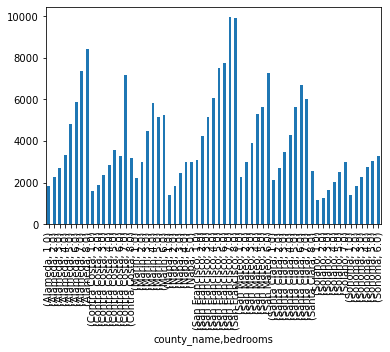

In [9]:
rentals_sf1.groupby(['county_name', 'bedrooms'])['rent'].mean().plot(kind='bar')

Note that in one line of pandas code we can aggregate, transform, and plot our data. But this plot has some issues. Let's see if we can't improve it.

In [12]:
_1 = rentals_sf1.groupby(['county_name', 'bedrooms'])['rent'].mean().unstack()
_1.head()

bedrooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
county_name,,,,,,,,
Alameda,1862.396037,2284.538409,2715.874074,3315.346895,4820.488152,5898.392857,7362.5,8400.0
Contra Costa,1596.991079,1874.641106,2390.508197,2831.713831,3547.841808,3258.636364,7172.5,3200.0
Marin,2209.910211,2998.448575,4476.835979,5837.602273,5145.666667,5250.000000,NaN,NaN
Napa,1387.362745,1846.914110,2447.333333,2998.593750,3009.000000,NaN,NaN,NaN
San Francisco,3099.179065,4225.756604,5151.170096,6064.077295,7525.666667,7750.000000,9950.0,9900.0


In [14]:
_2 = rentals_sf1.groupby(['bedrooms', 'county_name'])['rent'].mean().unstack()
_1.head()

county_name,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
bedrooms,,,,,,,,,
1.0,1862.396037,1596.991079,2209.910211,1387.362745,3099.179065,2266.792148,2143.095373,1143.470514,1403.868078
2.0,2284.538409,1874.641106,2998.448575,1846.914110,4225.756604,2975.375058,2721.721386,1277.712283,1830.113469
3.0,2715.874074,2390.508197,4476.835979,2447.333333,5151.170096,3888.506952,3451.772947,1640.565678,2284.307937
4.0,3315.346895,2831.713831,5837.602273,2998.593750,6064.077295,5292.336683,4280.278307,2043.212766,2738.465347
5.0,4820.488152,3547.841808,5145.666667,3009.000000,7525.666667,5633.618182,5642.350211,2491.250000,3037.500000


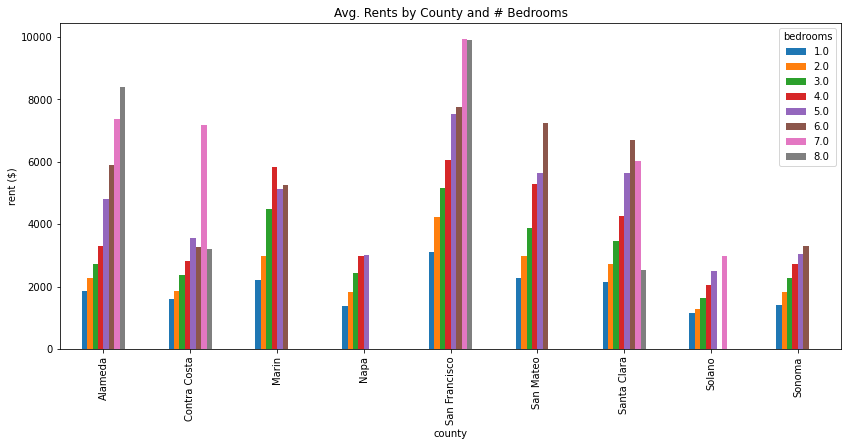

In [9]:
_ = rentals_sf1.groupby(['county_name', 'bedrooms'])['rent'].mean().unstack().plot(
    kind='bar', figsize=(14,6), title='Avg. Rents by County and # Bedrooms', ylabel='rent ($)', xlabel='county')

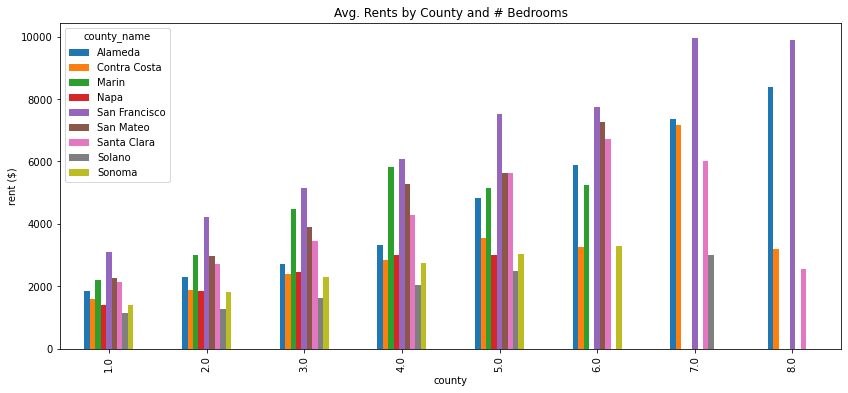

In [15]:
_2 = rentals_sf1.groupby(['bedrooms', 'county_name'])['rent'].mean().unstack().plot(
    kind='bar', figsize=(14,6), title='Avg. Rents by County and # Bedrooms', ylabel='rent ($)', xlabel='county')

**Question:** This plot is clearly more legible, but is it really showing us what want?

If we re-order the sequence of our group-by columns, we'll swap the rows and columns of the dataframe returned by `unstack()`:

<AxesSubplot:title={'center':'Average Rents by County and # Bedrooms'}, xlabel='# bedrooms', ylabel='rent ($)'>

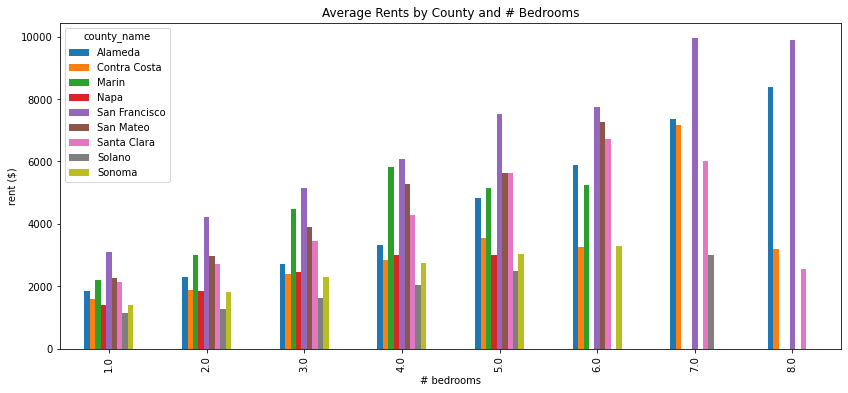

In [16]:
rentals_sf1.groupby(['bedrooms', 'county_name'])['rent'].mean().unstack().plot(
    kind='bar', figsize=(14,6), title='Average Rents by County and # Bedrooms',
    ylabel='rent ($)', xlabel='# bedrooms')

## 2.5 Pivot tables and cross-tabulations

For all you Excel wizards out there thinking "this is dumb it's just a pivot table"...you're right!

<AxesSubplot:title={'center':'Average Rents by County and Bedrooms'}, xlabel='bedrooms'>

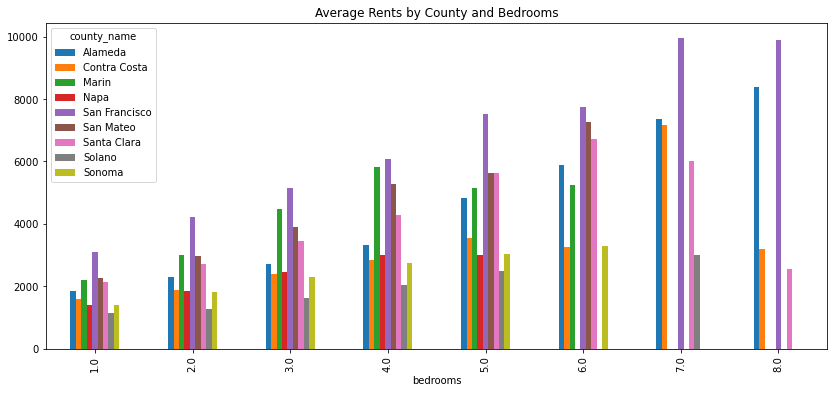

In [17]:
pd.pivot_table(rentals_sf1, values='rent', index=['bedrooms'], columns=['county_name']).plot(
    kind='bar', figsize=(14,6), title='Average Rents by County and Bedrooms')

Behind the scenes, pivot table is just doing a group-by and taking the mean.

In [19]:
pd.pivot_table(rentals_sf1, values='rent', index='bedrooms', columns='county_name')

county_name,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
bedrooms,,,,,,,,,
1.0,1862.396037,1596.991079,2209.910211,1387.362745,3099.179065,2266.792148,2143.095373,1143.470514,1403.868078
2.0,2284.538409,1874.641106,2998.448575,1846.914110,4225.756604,2975.375058,2721.721386,1277.712283,1830.113469
3.0,2715.874074,2390.508197,4476.835979,2447.333333,5151.170096,3888.506952,3451.772947,1640.565678,2284.307937
4.0,3315.346895,2831.713831,5837.602273,2998.593750,6064.077295,5292.336683,4280.278307,2043.212766,2738.465347
5.0,4820.488152,3547.841808,5145.666667,3009.000000,7525.666667,5633.618182,5642.350211,2491.250000,3037.500000
6.0,5898.392857,3258.636364,5250.000000,NaN,7750.000000,7260.000000,6704.545455,NaN,3295.000000
7.0,7362.500000,7172.500000,NaN,NaN,9950.000000,NaN,6028.571429,3000.000000,NaN
8.0,8400.000000,3200.000000,NaN,NaN,9900.000000,NaN,2550.000000,NaN,NaN


But you could specify other aggregation functions if you wanted. You can also add other useful features like marginals.

In [20]:
pd.pivot_table(rentals_sf1, values='rent', index='bedrooms', columns='county_name', aggfunc='mean', margins=False)

county_name,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
bedrooms,,,,,,,,,
1.0,1862.396037,1596.991079,2209.910211,1387.362745,3099.179065,2266.792148,2143.095373,1143.470514,1403.868078
2.0,2284.538409,1874.641106,2998.448575,1846.914110,4225.756604,2975.375058,2721.721386,1277.712283,1830.113469
3.0,2715.874074,2390.508197,4476.835979,2447.333333,5151.170096,3888.506952,3451.772947,1640.565678,2284.307937
4.0,3315.346895,2831.713831,5837.602273,2998.593750,6064.077295,5292.336683,4280.278307,2043.212766,2738.465347
5.0,4820.488152,3547.841808,5145.666667,3009.000000,7525.666667,5633.618182,5642.350211,2491.250000,3037.500000
6.0,5898.392857,3258.636364,5250.000000,NaN,7750.000000,7260.000000,6704.545455,NaN,3295.000000
7.0,7362.500000,7172.500000,NaN,NaN,9950.000000,NaN,6028.571429,3000.000000,NaN
8.0,8400.000000,3200.000000,NaN,NaN,9900.000000,NaN,2550.000000,NaN,NaN


In [22]:
pd.pivot_table(rentals_sf1, values='rent', index='bedrooms', columns='county_name', aggfunc='mean', margins=True)

county_name,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma,All
bedrooms,,,,,,,,,,
1.0,1862.396037,1596.991079,2209.910211,1387.362745,3099.179065,2266.792148,2143.095373,1143.470514,1403.868078,2083.173271
2.0,2284.538409,1874.641106,2998.448575,1846.914110,4225.756604,2975.375058,2721.721386,1277.712283,1830.113469,2547.455154
3.0,2715.874074,2390.508197,4476.835979,2447.333333,5151.170096,3888.506952,3451.772947,1640.565678,2284.307937,3271.394562
4.0,3315.346895,2831.713831,5837.602273,2998.593750,6064.077295,5292.336683,4280.278307,2043.212766,2738.465347,3885.334005
5.0,4820.488152,3547.841808,5145.666667,3009.000000,7525.666667,5633.618182,5642.350211,2491.250000,3037.500000,4779.177097
6.0,5898.392857,3258.636364,5250.000000,NaN,7750.000000,7260.000000,6704.545455,NaN,3295.000000,5089.702381
7.0,7362.500000,7172.500000,NaN,NaN,9950.000000,NaN,6028.571429,3000.000000,NaN,5395.769231
8.0,8400.000000,3200.000000,NaN,NaN,9900.000000,NaN,2550.000000,NaN,NaN,6012.500000
All,2276.640777,1986.574901,3331.101747,2129.948960,3962.882939,2914.964099,2709.559862,1365.882549,1820.996018,2581.310377


In [23]:
pd.pivot_table(rentals_sf1, values='rent', index='bedrooms', columns='county_name', aggfunc='count', margins=False)

county_name,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma
bedrooms,,,,,,,,,
1.0,4290.0,2242.0,568.0,102.0,2245.0,2598.0,7413.0,797.0,614.0
2.0,4361.0,3508.0,807.0,163.0,2120.0,2141.0,8973.0,1498.0,1225.0
3.0,1350.0,976.0,378.0,195.0,729.0,935.0,2484.0,472.0,315.0
4.0,467.0,629.0,176.0,64.0,207.0,199.0,945.0,188.0,101.0
5.0,211.0,177.0,15.0,5.0,15.0,55.0,237.0,32.0,4.0
6.0,28.0,33.0,2.0,NaN,4.0,5.0,11.0,NaN,1.0
7.0,4.0,4.0,NaN,NaN,1.0,NaN,7.0,10.0,NaN
8.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN


When you specify `count` as your aggregation method, you are doing **cross-
tabulation**.        

Cross-tabulation is such a common operation that pandas has a built-in function for _it_, too!

In [24]:
pd.crosstab(rentals_sf1['bedrooms'], rentals_sf1['county_name'], margins=True)

county_name,Alameda,Contra Costa,Marin,Napa,San Francisco,San Mateo,Santa Clara,Solano,Sonoma,All
bedrooms,,,,,,,,,,
1.0,4290,2242,568,102,2245,2598,7413,797,614,20869
2.0,4361,3508,807,163,2120,2141,8973,1498,1225,24796
3.0,1350,976,378,195,729,935,2484,472,315,7834
4.0,467,629,176,64,207,199,945,188,101,2976
5.0,211,177,15,5,15,55,237,32,4,751
6.0,28,33,2,0,4,5,11,0,1,84
7.0,4,4,0,0,1,0,7,10,0,26
8.0,1,1,0,0,1,0,1,0,0,4
All,10712,7570,1946,529,5322,5933,20071,2997,2260,57340


Getting a little fancy here, but cross-tab data lends itself nicely to higher-dimensional data visualization styles like the "heat map" below:

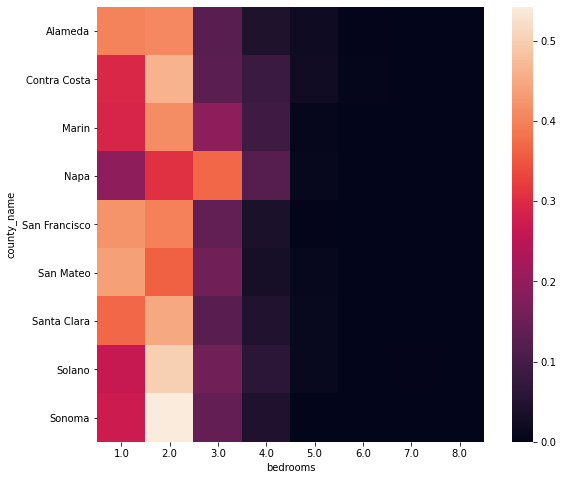

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
_ = sns.heatmap(
    pd.crosstab(rentals_sf1['county_name'], rentals_sf1['bedrooms'], normalize='index'), square=True, ax=ax)

# 3. Intro to Data Visualization

- 3.1. Ethics of Data Visualization 
- 3.2. Conceptual Overview
- 3.3. Matplotlib
- 3.4. Seaborn

## 3.1 Ethical Data Visualization

It is exceedingly easy to lie with data visualization. You **will** be tempted to do so, if only subconsciouly, in order to nudge your results towards support for your hypotheses. Be aware, and learn to recognize this tendency in yourself.

A victimless crime? Perhaps.

But perhaps not:

In [26]:
%%html
<iframe src="https://www.cbsnews.com/news/how-purdue-used-misleading-charts-to-hide-oxycontins-addictive-power/" width=100% height=800></iframe>

## 3.2 Conceptual overview

### 3.2.1 Categorical vs. Continuous data

<AxesSubplot:title={'center':'Price ($)'}, ylabel='Density'>

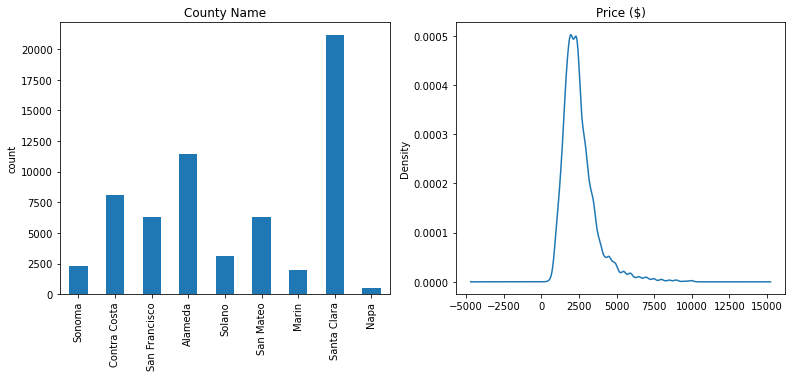

In [27]:
fig, axarr = plt.subplots(1, 2, figsize=(13,5))
rentals_sf1['county_name'].value_counts(sort=False).plot(kind='bar', ax=axarr[0], title='County Name')
axarr[0].set_ylabel("count")
rentals_sf1['rent'].plot(kind='kde', ax=axarr[1], title='Price ($)')

### 3.2.2 Building blocks

- **shape**: points, lines, bars, areas (fill/patch)
- **size**: of shape, figure, etc.
- **color**: hue, opacity, gradient (colormap)
- **axes (dimensionality)**: tick marks, labels
- **auxiliary data**: legend, margin plots, annotation

![](https://matplotlib.org/stable/_images/sphx_glr_categorical_variables_001_2_0x.png)

### 3.2.3 Dimensionality

**Dimensionality**: number of axes of variation

**Question:** How many dimensions are shown in the following examples?

<img src="https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iCIEic94rsFk/v0/-1x-1.png" width=800px >

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/SoilTexture_USDA.png/500px-SoilTexture_USDA.png)

<img src="https://raw.githubusercontent.com/zonination/perceptions/master/joy1.png" width=700px>

<img src="https://flowingdata.com/wp-content/uploads/2013/09/most-unisex-names2.png" width=600px>

In [28]:
%%html
<iframe src="//www.gapminder.org/tools/?embedded=true#$ui;&chart-type=bubbles&url=v1" style="width: 100%; height: 500px; margin: 0 0 0 0; border: 1px solid grey;" allowfullscreen></iframe>

**EXAMPLES:**

- **1d**: [histogram](https://matplotlib.org/stable/plot_types/stats/hist_plot.html), [kernel density estimate (KDE)](https://seaborn.pydata.org/tutorial/distributions.html#kernel-density-estimation), [rugplot](https://seaborn.pydata.org/generated/seaborn.rugplot.html#seaborn.rugplot)/[eventplot](https://matplotlib.org/stable/plot_types/stats/eventplot.html), [pie chart](https://matplotlib.org/stable/plot_types/stats/pie.html)

- **1.5d**: [boxplot](https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html), [grouped histogram](https://seaborn.pydata.org/tutorial/distributions.html#conditioning-on-other-variables), [grouped KDE](https://seaborn.pydata.org/tutorial/distributions.html#id1)

- **2d**: [scatter](https://matplotlib.org/stable/plot_types/basic/scatter_plot.html), [line](https://matplotlib.org/stable/plot_types/basic/plot.html), [bar](https://matplotlib.org/stable/plot_types/basic/bar.html#sphx-glr-plot-types-basic-bar-py), [boxplot](https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html), maps (?)

- **2.5d**: [categorical scatter](https://seaborn.pydata.org/tutorial/categorical.html#categorical-scatterplots), [grouped boxplot](https://seaborn.pydata.org/tutorial/categorical.html#boxplots), [grouped line](https://seaborn.pydata.org/generated/seaborn.lineplot.html), [grouped scatter](https://seaborn.pydata.org/tutorial/relational.html#relating-variables-with-scatter-plots), [bubble](https://plotly.com/python/bubble-charts/)

- **3d+**: [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html), [contour](https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_demo.html), [bivariate distribution](https://seaborn.pydata.org/tutorial/distributions.html#visualizing-bivariate-distributions), [hexbin](https://matplotlib.org/stable/plot_types/stats/hexbin.html), [raster images](https://matplotlib.org/stable/plot_types/arrays/imshow.html), 


## 3.3. Matplotlib

Matplotlib is to data viz what NumPy is to data analysis in Python. Nearly every other plotting library is built on top of it. For this reason, Matplotlib is the most flexible and powerful of Python's data viz packages. Almost everything that can be done in the more sophisticated plotting libraries can be implemented in pure Matplotlib with a little bit of extra work.



In practice, I find Matplotlib most useful for two scenarios:
1. quick 1- or 2d data viz (histograms, scatterplots, etc.) for array-based data
2. control of figure components for non-standard plot types

### 3.3.1. The basics: `Figure` vs. `Axes` vs. the rest 

<img src="https://matplotlib.org/stable/_images/anatomy.png" width=700px>

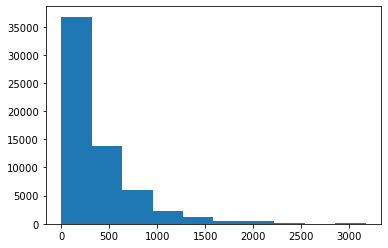

In [29]:
plt.hist(rentals_sf1['P0010001'])
plt.show()

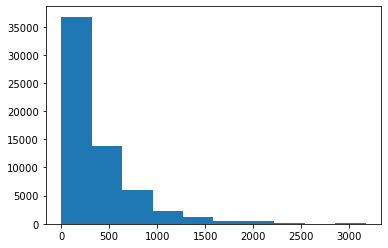

In [30]:
fig, ax = plt.subplots()
ax.hist(rentals_sf1['P0010001'])
plt.show()

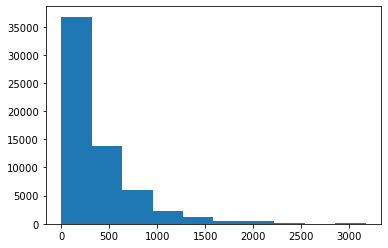

In [31]:
fig, ax = plt.subplots()
_ = ax.hist(rentals_sf1['P0010001'])

### 3.3.2. Subplots and axes

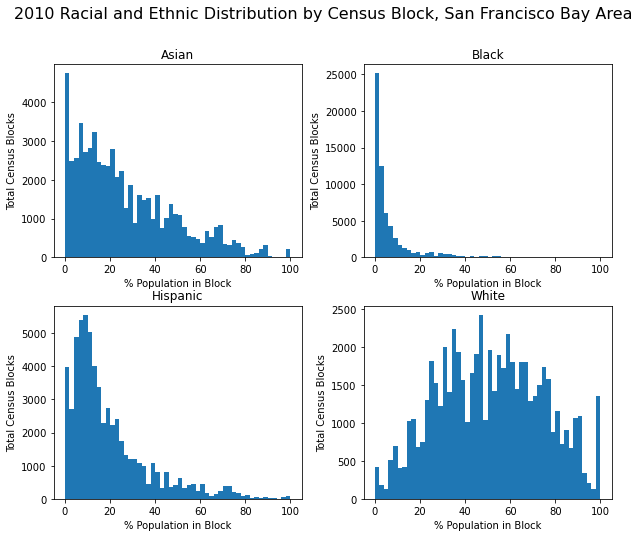

In [32]:
fig = plt.figure(1, figsize=(10,8), )
fig.suptitle("2010 Racial and Ethnic Distribution by Census Block, San Francisco Bay Area", fontsize=16)

ax1 = plt.subplot(221)
ax1.hist(rentals_sf1['pct_asian'], bins=50)
ax1.set_title("Asian")
ax1.set_xlabel('% Population in Block')
ax1.set_ylabel('Total Census Blocks')

ax2 = plt.subplot(222)
ax2.hist(rentals_sf1['pct_black'], bins=50)
ax2.set_title("Black")
ax2.set_xlabel('% Population in Block')
ax2.set_ylabel('Total Census Blocks')

ax3 = plt.subplot(223)
ax3.hist(rentals_sf1['pct_hisp'], bins=50)
ax3.set_title("Hispanic")
ax3.set_xlabel('% Population in Block')
ax3.set_ylabel('Total Census Blocks')

ax4 = plt.subplot(224)
ax4.hist(rentals_sf1['pct_white'], bins=50)
ax4.set_title("White")
ax4.set_xlabel('% Population in Block')
ax4.set_ylabel('Total Census Blocks')

plt.subplots_adjust(wspace=.25, hspace=.25)
plt.show()

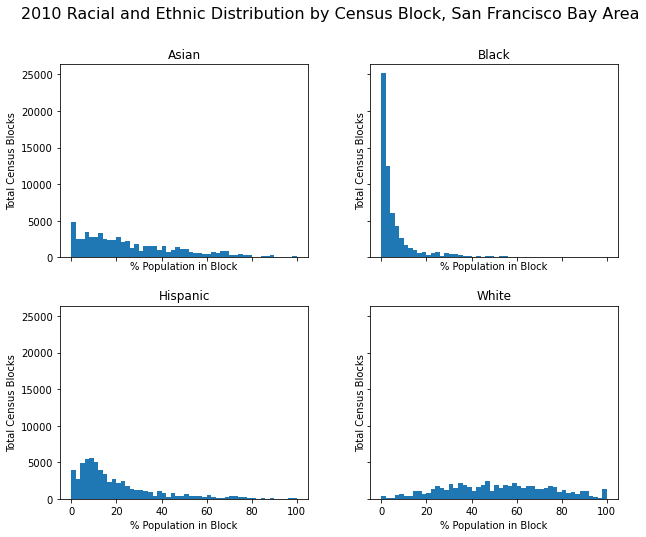

In [33]:
fig, axarr = plt.subplots(2,2, figsize=(10,8), sharey=True, sharex=True)
fig.suptitle("2010 Racial and Ethnic Distribution by Census Block, San Francisco Bay Area", fontsize=16)

axarr[0, 0].hist(rentals_sf1['pct_asian'], bins=50)
axarr[0, 0].set_title("Asian")
axarr[0, 0].set_xlabel('% Population in Block')
axarr[0, 0].set_ylabel('Total Census Blocks')

axarr[0, 1].hist(rentals_sf1['pct_black'], bins=50)
axarr[0, 1].set_title("Black")
axarr[0, 1].set_xlabel('% Population in Block')
axarr[0, 1].set_ylabel('Total Census Blocks')

axarr[1, 0].hist(rentals_sf1['pct_hisp'], bins=50)
axarr[1, 0].set_title("Hispanic")
axarr[1, 0].set_xlabel('% Population in Block')
axarr[1, 0].set_ylabel('Total Census Blocks')

axarr[1, 1].hist(rentals_sf1['pct_white'], bins=50)
axarr[1, 1].set_title("White")
axarr[1, 1].set_xlabel('% Population in Block')
axarr[1, 1].set_ylabel('Total Census Blocks')

plt.subplots_adjust(wspace=.25, hspace=.25)
plt.show()

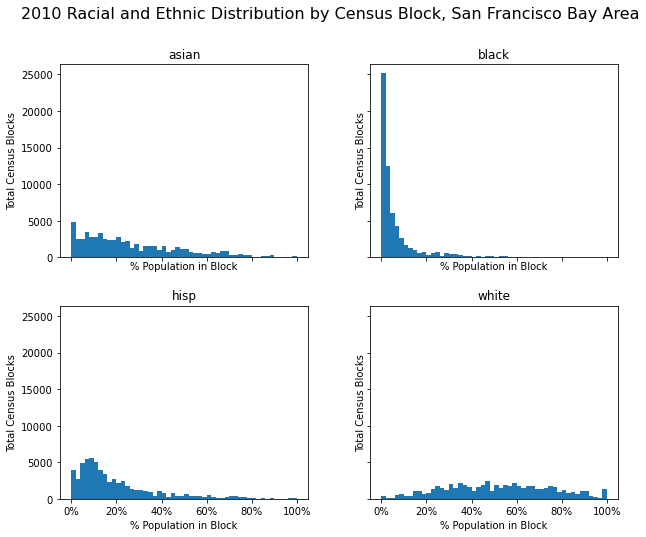

In [34]:
import matplotlib.ticker as ticker

fig, axarr = plt.subplots(2,2, figsize=(10,8), sharey=True, sharex=True)
fig.suptitle("2010 Racial and Ethnic Distribution by Census Block, San Francisco Bay Area", fontsize=16)

cats = ['asian', 'black', 'hisp', 'white']

for i, ax in enumerate(axarr.flatten()):
    ax.hist(rentals_sf1['pct_{0}'.format(cats[i])], bins=50)
    ax.set_title(cats[i])
    ax.set_xlabel('% Population in Block')
    ax.set_ylabel('Total Census Blocks')
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

plt.subplots_adjust(wspace=.25, hspace=.25)
plt.show()

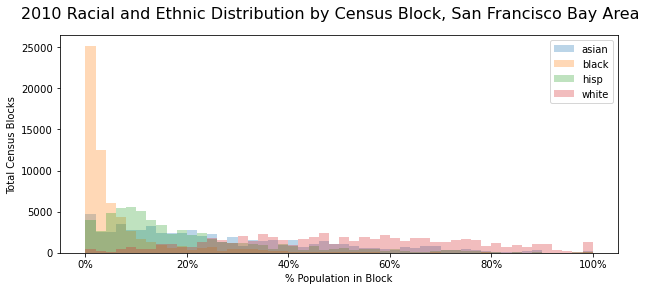

In [35]:
fig, ax= plt.subplots(figsize=(10, 4))
fig.suptitle("2010 Racial and Ethnic Distribution by Census Block, San Francisco Bay Area", fontsize=16)

cats = ['asian', 'black', 'hisp', 'white']

for cat in cats:
    ax.hist(rentals_sf1['pct_{0}'.format(cat)], bins=50, alpha=0.3, label=cat)
    ax.set_xlabel('% Population in Block')
    ax.set_ylabel('Total Census Blocks')
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
    
ax.legend()

plt.subplots_adjust(wspace=.25, hspace=.25)
plt.show()

### 3.3.3 Bivariate data

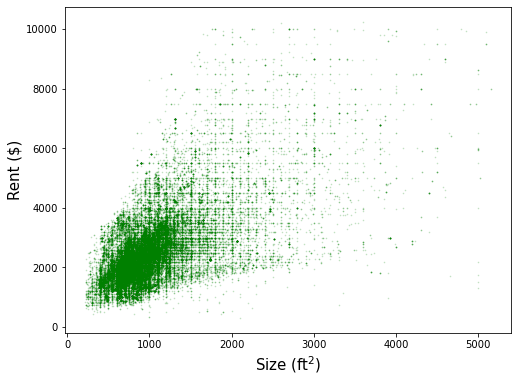

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
foo = ax.scatter(rentals_sf1['sqft'], rentals_sf1['rent'], c='g', alpha=0.2, s=0.4)
ax.set_xlabel("Size (ft$^2$)", fontsize=15)
_ = ax.set_ylabel('Rent ($)', fontsize=15)

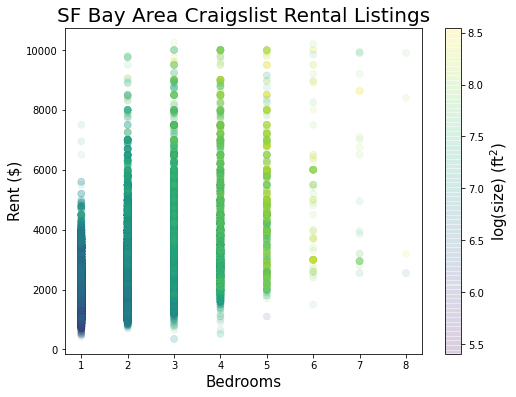

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("SF Bay Area Craigslist Rental Listings", fontsize=20)
ax.set_xlabel('Bedrooms', fontsize=15)
ax.set_ylabel('Rent ($)', fontsize=15)
foo = ax.scatter(
    rentals_sf1['bedrooms'], rentals_sf1['rent'], c=np.log(rentals_sf1['sqft']), lw=0.5, alpha=.1, s=50)
cbar = fig.colorbar(foo)
cbar.set_label("log(size) (ft$^2$)", fontsize=15)

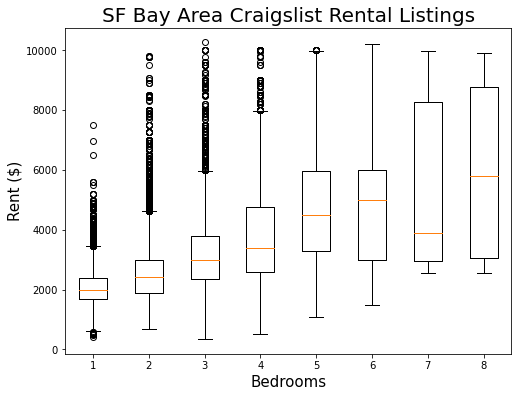

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("SF Bay Area Craigslist Rental Listings", fontsize=20)
ax.set_xlabel('Bedrooms', fontsize=15)
ax.set_ylabel('Rent ($)', fontsize=15)
_ = ax.boxplot([x['rent'] for i, x in rentals_sf1.groupby('bedrooms')])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=rentals_sf1, x='bedrooms', y='rent', ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(data=rentals_sf1, x='bedrooms', y='rent', alpha=0.1, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.violinplot(data=rentals_sf1, x='bedrooms', y='rent',ax=ax)

## 3.4 Seaborn

### 3.4.1 The basics

Matplotlib, for DataFrames! In fact, it works directly on top of `fig` and `ax` objects:

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(data=rentals_sf1, x='bedrooms', y='rent', alpha=0.1, ax=ax)
ax.set_title("SF Bay Area Craigslist Rental Listings", fontsize=20)
ax.set_xlabel('Bedrooms', fontsize=15)
_ = ax.set_ylabel('Rent ($)', fontsize=15)
fig.set_facecolor('lightgrey')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.kdeplot(data=rentals_sf1, x="rent", hue='county_name', fill=True, ax=ax)

### 3.4.2 Facets

Seaborn makes it easy to create a grid of subplots on-the-fly. In Seaborn parlance, each subplot is a `Facet`, and the grid is a `FacetGrid`. Seaborn allows you to specify a `FacetGrid` in which the rows/columns correspond to column values from your dataframe. Below, we define a FacetGrid where the facets are defined by `county_name`, and use the `col_wrap` argument to tell Seaborn to start a new row after every 3rd column.

In [ ]:
g = sns.FacetGrid(rentals_sf1, col="county_name", col_wrap=3, height=2.5, aspect=1.5)
g.map(sns.histplot, "rent")

In [ ]:
g = sns.FacetGrid(rentals_sf1, col="county_name", col_wrap=3, height=2.5, aspect=1.5)
g.map(sns.kdeplot, "rent", fill=True)

In [ ]:
from matplotlib import rcParams

with sns.axes_style({"style": "white", "axes.facecolor": (0, 0, 0, 0)}):
    g = sns.FacetGrid(rentals_sf1, row="county_name", hue="county_name", aspect=20, height=.75)
    g.map(sns.kdeplot, "rent",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=.5, linewidth=1.5)
    g.figure.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[])
    g.despine( left=True)
    g.set_axis_labels("Rent ($)", "", fontsize=15)
    g.set_titles(row_template='{row_name}')
    for ax in g.axes:
        title = ax[0].get_title()
        ax[0].set_title("")
        ax[0].set_ylabel(title, rotation=0, loc='bottom', labelpad=0)


### 3.4.3 High-dimension plots

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.kdeplot(
    x="sqft", y="rent", data=rentals_sf1, thresh=0, fill=True, cmap='magma', alpha=0.7)

In [ ]:
sns.jointplot(
    x="sqft", y="rent", kind="hex", data=rentals_sf1, cmap='magma', joint_kws={"mincnt": 1, "gridsize":30})

In [ ]:
sns.pairplot(rentals_sf1[['rent', 'sqft', 'pop_sqmi', 'pct_white']],
    plot_kws = {'alpha': 0.05, 's': 1, 'edgecolor': 'none', 'facecolor':'k'});

### 3.4.4. A bit of color theory

In [3]:
%%html
<iframe src="https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html" width=100% height=700></iframe>

#### 3.4.4.1 The Three Components of Color

1. Hue

In [6]:
sns.color_palette("hls", 8)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

2. Saturation

In [7]:
sns.color_palette("blend:grey,b", 8)

[(0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.4310957324106113, 0.4310957324106113, 0.5722722029988466),
 (0.3582622068435217, 0.3582622068435217, 0.6445367166474433),
 (0.2873971549404075, 0.2873971549404075, 0.7148481353325644),
 (0.21456362937331797, 0.21456362937331797, 0.7871126489811611),
 (0.14369857747020376, 0.14369857747020376, 0.8574240676662822),
 (0.0708650519031142, 0.0708650519031142, 0.9296885813148789),
 (0.0, 0.0, 1.0)]

3. Lightness

In [8]:
sns.cubehelix_palette(8, start=.25, rot=-.25, reverse=True)

[[0.1676124288206785, 0.12168378009569247, 0.24493209028077442],
 [0.25719212909752504, 0.22039345367928442, 0.3980974201030203],
 [0.3315259381236118, 0.3244953194332093, 0.5282698511453637],
 [0.4040693859926358, 0.43902378590530383, 0.6430510471441738],
 [0.4764563969141741, 0.5515570377266595, 0.7333097883591035],
 [0.5615918212430975, 0.6670782376100594, 0.8084244613507879],
 [0.6629603011558388, 0.7770571967906177, 0.8689938012762111],
 [0.7801075672866592, 0.8741945391838343, 0.9197573835143085]]

#### 3.4.4.2. Color Palettes

Categorical/Qualitative

<center><img src="https://seaborn.pydata.org/_images/color_palettes_22_0.png" width=500></center>

In [9]:
sns.color_palette("pastel", 7)

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236)]

Circular color systems

In [10]:
# HLS
sns.color_palette("hls", 7)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.8169142857142857, 0.33999999999999997),
 (0.4573714285714283, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.6683428571428571),
 (0.33999999999999997, 0.6059428571428571, 0.86),
 (0.5197714285714281, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7545142857142858)]

In [11]:
# HUSL
sns.color_palette("husl", 7)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.775731904186273, 0.5784925270759935, 0.19475566538551872),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.9587050080494405, 0.36622595657917456, 0.9231469575614251)]

In [12]:
# colorbrewer palettes
sns.color_palette("Set2", 7)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]

Sequential

In [13]:
# perceptually uniform
sns.color_palette("rocket_r", 10)

[(0.96810471, 0.78634563, 0.66773889),
 (0.96388426, 0.64484214, 0.4861196),
 (0.95626788, 0.49187351, 0.33985601),
 (0.93078135, 0.31373977, 0.24468803),
 (0.85281737, 0.15657772, 0.27909826),
 (0.72398193, 0.08688725, 0.33943958),
 (0.57077365, 0.11135597, 0.35827146),
 (0.41282936, 0.12164769, 0.33467689),
 (0.26930915, 0.1091727, 0.2772502),
 (0.13501631, 0.07585609, 0.19044109)]

In [14]:
# cubehelix
sns.color_palette("ch:start=.5,rot=-.5", 10)

[(0.7611058395410276, 0.897713045748989, 0.8454349452836011),
 (0.6475389924250959, 0.8312061179534195, 0.7988690531356617),
 (0.5516174331469553, 0.7533438201390327, 0.765085969337711),
 (0.47599829224141754, 0.6647212472467017, 0.7336470666017856),
 (0.41944085427823424, 0.5678340676140039, 0.6945501868189554),
 (0.3790627817754598, 0.4716977553188698, 0.6429510329318763),
 (0.34351942619215814, 0.3706877966569698, 0.5686561064138482),
 (0.306349241555757, 0.27452187508371506, 0.47281619224112104),
 (0.258495235421288, 0.18722914407204005, 0.3585211949837789),
 (0.19219588654040817, 0.11144874684946916, 0.2327834607416993)]

Divergent

In [15]:
sns.color_palette("Spectral", 10)

[(0.8141484044598232, 0.2196847366397539, 0.3048058439061899),
 (0.9330257593233372, 0.3913110342176086, 0.27197231833910035),
 (0.9817762399077278, 0.6073817762399076, 0.3457900807381776),
 (0.9946943483275663, 0.8092272202998846, 0.48696655132641287),
 (0.9982314494425221, 0.9451749327181853, 0.6570549788542868),
 (0.9557862360630527, 0.9823144944252211, 0.6800461361014996),
 (0.8202998846597465, 0.9275663206459055, 0.6126874279123413),
 (0.5910034602076126, 0.835524798154556, 0.6442906574394464),
 (0.3600153787004998, 0.7161860822760476, 0.6655132641291811),
 (0.21299500192233756, 0.5114186851211072, 0.730795847750865)]

In [16]:
sns.color_palette("coolwarm", 10)

[(0.3383765114431373, 0.45281860883137254, 0.8793170768784313),
 (0.4570464785254902, 0.5940055499294118, 0.963029229690196),
 (0.5814861481882353, 0.7134505955294117, 0.9983143529411764),
 (0.7087196897176471, 0.8057213889294117, 0.9811168090470588),
 (0.8180564934117647, 0.8555896775450981, 0.9146376165490196),
 (0.9094595977529412, 0.8393864797647058, 0.8003313524235294),
 (0.9616447383764706, 0.7580291825411765, 0.6617823791647058),
 (0.963806056435294, 0.6341884145294118, 0.5137208491529413),
 (0.9182816725843137, 0.48417347218039214, 0.37779392507058823),
 (0.8301865219490197, 0.30473276355294115, 0.25489142806666665)]

In [17]:
# perceptually uniform
sns.color_palette("vlag", 10)

[(0.34125337, 0.50923419, 0.73874905),
 (0.49566225, 0.60454154, 0.76238852),
 (0.64061445, 0.70437326, 0.80497621),
 (0.79159841, 0.81658489, 0.86776906),
 (0.93827772, 0.9322888, 0.94432312),
 (0.96784372, 0.91616744, 0.91126063),
 (0.90235365, 0.77267117, 0.76467793),
 (0.84190106, 0.62760645, 0.61740899),
 (0.7862306, 0.49245398, 0.48267247),
 (0.72743485, 0.35773314, 0.35378465)]

In [18]:
# custom
sns.diverging_palette(250, 30, s=99, l=65, center="dark", n=10)

[(0.30333210366809527, 0.629208174731071, 0.99625585181397),
 (0.2668380379908195, 0.5231597318535448, 0.8139828559389387),
 (0.23034397231354375, 0.41711128897601857, 0.6317098600639073),
 (0.19189741302755772, 0.30538907686808897, 0.43968495376503736),
 (0.15540334735028197, 0.1993406339905627, 0.2574119578900059),
 (0.25495361887621426, 0.17832084102122892, 0.12275049800980606),
 (0.4303894069785794, 0.25412340524029225, 0.10186171314876666),
 (0.6152113034427272, 0.3339815335466897, 0.07985534332759771),
 (0.7906470915450924, 0.409784097765753, 0.058966558466558294),
 (0.9660828796474575, 0.4855866619848163, 0.0380777736055189)]

Matplotlib colormaps

In [19]:
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet',  'turbo', 'nipy_spectral', 'gist_ncar'])]

nrows = [len(cmap_list) for cmap_category, cmap_list in cmaps]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows, figsize=(10, nrows / 3))
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()

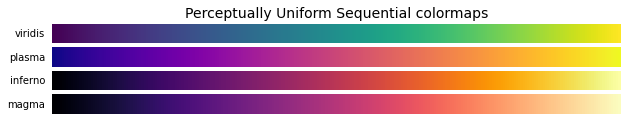

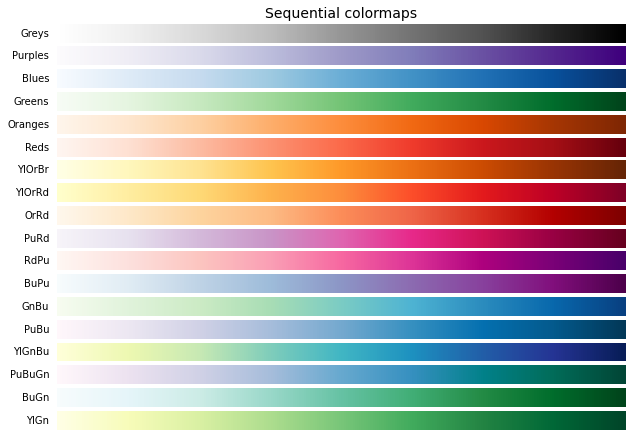

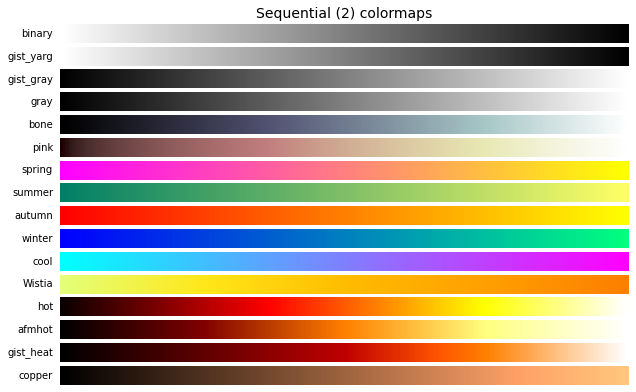

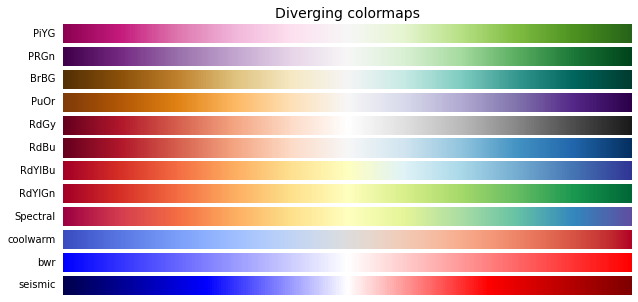

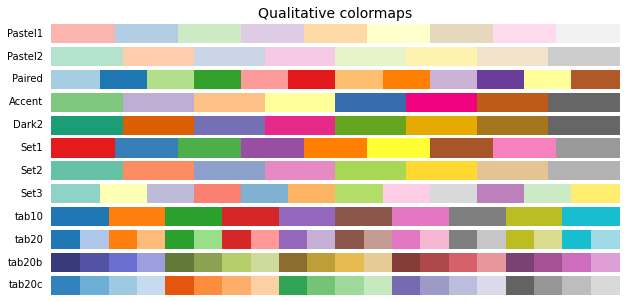

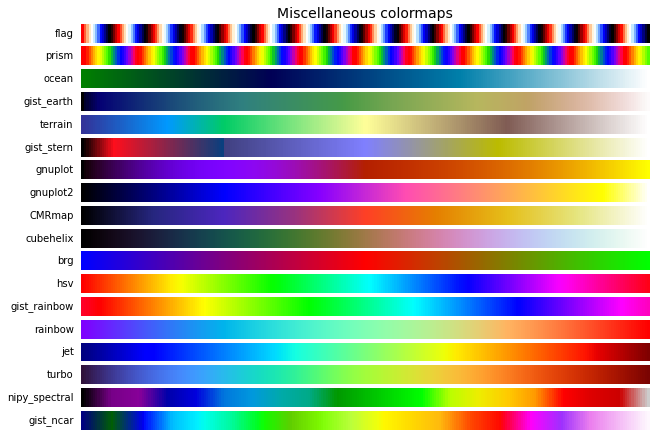

In [20]:
for i, cmap in enumerate(cmaps):
    cmap_category, cmap_list = cmap
    plot_color_gradients(cmap_category, cmap_list, nrows[i])

#### 3.4.4.3 More on Color
- https://www.boronine.com/2012/03/26/Color-Spaces-for-Human-Beings/
- https://colorbrewer2.org/
- https://earthobservatory.nasa.gov/blogs/elegantfigures/2013/08/05/subtleties-of-color-part-1-of-6/
- https://matplotlib.org/2.0.2/users/colormaps.html

# 4. For next time

- Data viz. examples
- HW3
- GitHub pages

# 5. Questions?